# Inverted encoding models
In the past year, I've seen several papers and posters (VSS, ICON) about 'inverted encoding models', mainly from the labs of John Serences and Tommy Sprague. This notebook describes the process of estimating encoding models of neuroimaging data (e.g. fMRI) and subsequently inverting them. It is based on [code](https://github.com/tommysprague/IEM-tutorial) from Tommy Sprague's github.

First some imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

## 1. The data

Let's simulate some data. Suppose that our brain data (let's say fMRI voxels) consists of 200 trials (in which a particular stimulus is presented) and 100 voxels. (Usually, you'd use more voxels, probably, but this makes the estimation of encoding models more difficult, because OLS fails when the number of features/variables is larger than the number of samples; in that case, you'd need to use regularized models, like ridge regression.) So, our brain-data is of shape $200 \times 100$. Now, suppose that in each trial the participant saw a single stimulus with two 'levels', thus making this a binary variable (e.g. two different stimulus orientations, two colors, whatever). We'll use the codes 0 and 1 to indicate the two levels of this stimulus-feature. The shape of the array representing this stimulus information is of shape $100 \times 1$.

We'll assume that the first 100 trials are of 'level' 0 and the last 100 trials are of 'level' 1. We'll simulate the brain-data with activity drawn from a normal distribution ($\mu = 0,\ \sigma = 1$).

In [2]:
n_trials = 200
n_voxels = 100

stimulus = np.repeat([0, 1], repeats=n_trials / 2)
brain = np.random.normal(0, 1, size=(n_trials, n_voxels))

Now, let's simulate some 'effect'. Suppose that the trials with stimuli of level 1 show an increase of activity in only the 'even' voxels (i.e., voxel 0, 2, 4, ... 198). We'll also plot the activity (y-axis) of all voxels (different lines) across all trials (x-axis) and the corresponding stimulus levels (thick blue line).

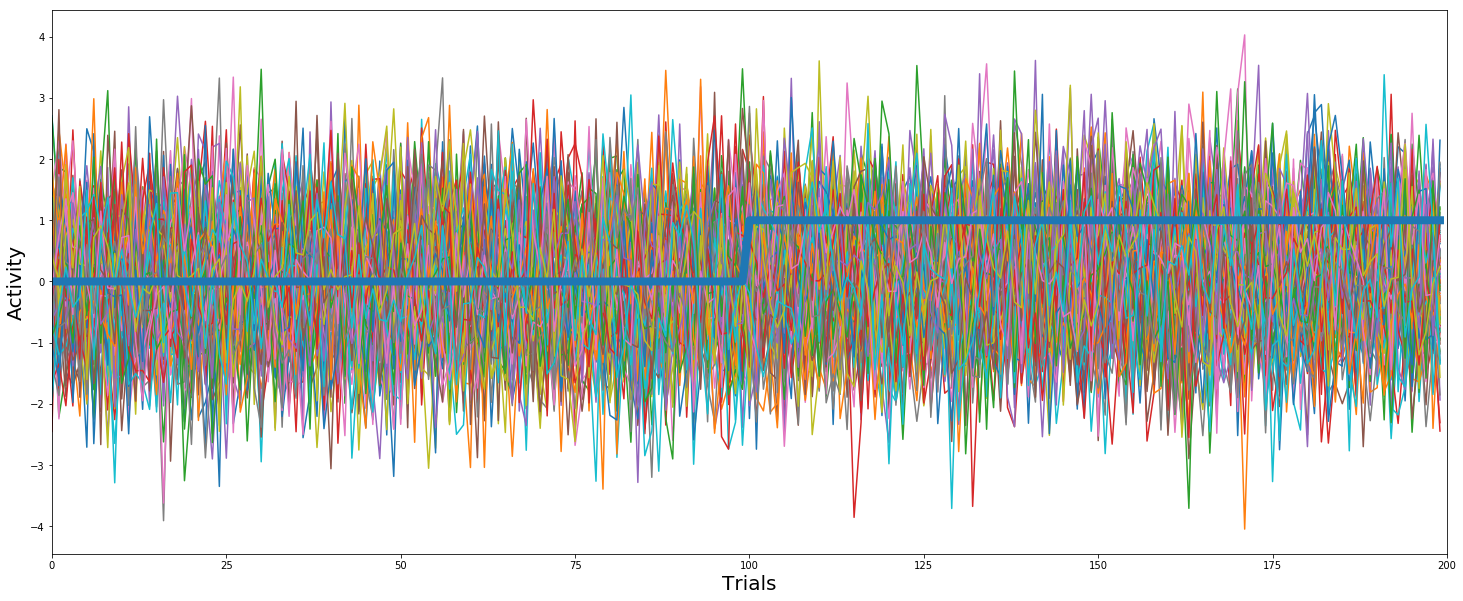

In [3]:
brain[100:200, 0:n_voxels:2] += 0.25

plt.figure(figsize=(25, 10))
plt.plot(brain)
plt.plot(stimulus, lw=8)
plt.xlim(0, n_trials)
plt.xlabel('Trials', fontsize=20)
plt.ylabel('Activity', fontsize=20)
plt.show()

## 2. A typical 'decoding' analysis 
Personally, I've worked at lot with "multivoxel pattern analyses" (MVPA) in which I apply machine learning models to make predictions about stimulus/task-features based on brain-data (usually fMRI). This is a type of 'decoding model', in which we treat the brain-data as (predictive) variables and the stimulus/task-feature(s) as the to-be-predicted target. Now, just for comparison to the 'inverted encoding models' (which *can* be used as a type of 'decoder') later, let's implement a simple decoding pipeline that aims to predict our stimulus variable (with levels 0 and 1) from the brain-data. We'll use scikit-learn for that of course.

First, let's define our variables. Given that this is a decoding model, we'll refer to the brain-data as `X_dec` (I usually use the symbol/name $X$ for the data that 'aims to explain') and the stimulus-variable as `y_dec` (I usually use the symbol/name $y$ for the data that 'is to-be explained').

In [4]:
X_dec = brain
y_dec = stimulus

Let's define a simple pipeline that does feature scaling and prediction using a linear SVM (seemingly the favorite classifier in cognitive neuroscience):

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])

And let's evaluate the cross-validated prediction accuracy:

In [6]:
scores_dec = cross_val_score(pipeline, X=X_dec, y=y_dec, cv=5)
print("Scores for the decoding model: %.3f (%.3f)" % (scores_dec.mean(), scores_dec.std()))

Scores for the decoding model: 0.705 (0.029)


Alright, this is quite good. Now, let's check out how 'inverted encoding models' work.

## 3. Encoding models and how to invert them
For these 'inverted encoding models', we of course first need to estimate an encoding model before we can invert them! In contrast to the (machine-learning based) 'decoding model' we just discussed, which aims to predict the stimulus-feature from the brain-data (brain &rarr; stimulus), encoding models aim to investigate the influence of the stimulus on the brain (stimulus &rarr; brain; e.g. the traditional GLM-based 'statistical parametric mapping' models in fMRI).

As such, let's give the data sensible names for the encoding step:

In [7]:
X_enc = stimulus[:, np.newaxis]  # add axis of linear algebra operations later
y_enc = brain

Alright, encoding models estimate the influence of the stimulus on the brain-data. The most often-used (I think) method is to simply use the GLM to estimate the (encoding) weights (usually called 'beta-weights'). These weights are often estimated in a separate model for each voxel. Fortunately, we can estimate all these models at the same time in the GLM using linear algebra. As such, we can estimate the beta-weights, $\beta$, for all voxels (resulting in an array of shape $1 \times 100$) using the predictors ($X$, of shape $200 \times 1$) to model the brain-data ($y$, of shape $200 \times 100$):

\begin{align}
\mathbf{\beta} = (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y}
\end{align}

Let's do that here:

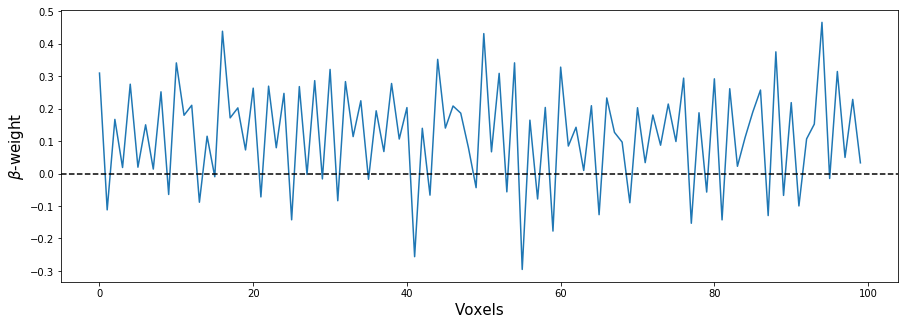

In [8]:
betas_enc = np.linalg.inv(X_enc.T.dot(X_enc)).dot(X_enc.T).dot(y_enc)

plt.figure(figsize=(15, 5))
plt.plot(betas_enc.T)
plt.axhline(0, ls='--', c='black')
plt.xlabel('Voxels', fontsize=15)
plt.ylabel(r'$\beta$-weight', fontsize=15)
plt.show()

As you can see, the weights nicely show that only the 'even' voxels show a $\beta$-weight above 0.

Now, the 'inversion' of the encoding models is simply rearranging the formula for the beta-weights such that we estimate $X$ from the components $y$ and $\beta$, which comes down to:

\begin{align}
\mathbf{X}_{inverted} = (\beta\beta')^{-1}\beta\mathbf{y}
\end{align}

Let's do that below:

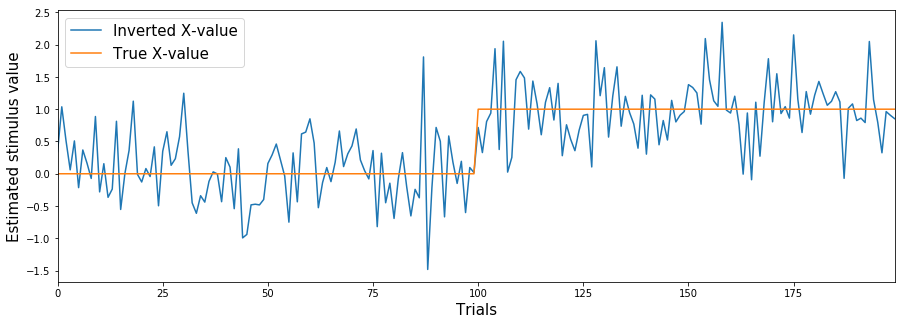

In [9]:
X_inv = np.linalg.inv(betas_enc.dot(betas_enc.T)).dot(betas_enc).dot(y_enc.T)
plt.figure(figsize=(15, 5))
plt.plot(X_inv.T)
plt.plot(X_enc)
plt.xlabel('Trials', fontsize=15)
plt.ylabel('Estimated stimulus value', fontsize=15)
plt.xlim(0, n_trials - 1)
plt.legend(['Inverted X-value', 'True X-value'], fontsize=15)
plt.show()

In fact, because we have a binary stimulus-feature (0, 1), we can easily 'convert' this reconstructed $X$-values into a 'decoding model' by predicting level 1 for when the inverted $X$-value is above 0.5 and 0 elsewhere:

\begin{align}
prediction = \begin{cases}
    1,& \text{if } X_{inv} > 0.5\\
    0,              & \text{otherwise}
\end{cases}
\end{align}

Let convert the inverted X-values into predictions and let's evaluate accuracy:

In [12]:
dec_score = np.mean((X_inv > 0.5).astype(int) == X_enc.T)
print(dec_score)

0.835


Much higher than the original decoding analysis! Of course, this is probably because we did not cross-validate the 'inverted encoding model' analysis (but we did this in the decoding analysis). It is easy to cross-validate the (inverted) encoding model as follows:

\begin{align}
\mathbf{\beta}_{train} = (\mathbf{X}_{train}'\mathbf{X}_{train})^{-1}\mathbf{X}_{train}'\mathbf{y}_{train}
\end{align}

\begin{align}
\mathbf{X}_{test} = (\mathbf{\beta}_{train}\mathbf{\beta}_{train}')^{-1}\mathbf{\beta}_{train}\mathbf{y}'
\end{align}

Alright, let's check out how our inverted-encoding-model-converted-to-decoding model does when it's cross-validated:

In [11]:
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits)
cv_scores = np.zeros((n_splits, 1))

for i, (train_idx, test_idx) in enumerate(skf.split(X_dec, y_dec)):
    X_train, X_test = X_enc[train_idx], X_enc[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]
    betas = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    X_inv_test = np.linalg.inv(betas.dot(betas.T)).dot(betas).dot(y_test.T)
    cv_scores[i] = ((X_inv_test.T > 0.5).astype(int) == X_test).mean()

print("Cross-valided scores: %.3f (%.3f)" % (cv_scores.mean(), cv_scores.std()))

Cross-valided scores: 0.730 (0.030)


That is quite a good score! Lower than the un-crossvalidated score (as expected), but comparable to the 'direct' decoding approach (using the SVM)!